<a href="https://colab.research.google.com/github/Nidjay78/facialExpressionRecog/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython.display import Image, HTML
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
import keras
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dropout, Activation, Average
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import base64
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.engine import training
from keras.models import Model, Input
from tensorflow.python.framework.ops import Tensor
from typing import Tuple, List
import glob
import numpy as np

from PIL import Image
from io import BytesIO
from IPython.display import HTML



# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_id = "1VyT9-DFzPdVRqpbjzh6Kwfta0IfbdVdy" 

"1VyT9-DFzPdVRqpbjzh6Kwfta0IfbdVdy" #Facialexpressionrecognition Dataset
"1nWMnLD7LQpJLJ3uv-fyvlb1dC2EioReS" #FEC Dataset


# Download zip file from gDrive
zip_file = drive.CreateFile({'id': file_id})
zip_file.GetContentFile('facialexpressionrecognition.zip')

In [ ]:
!unzip -n 'facialexpressionrecognition.zip' -d ./

Archive:  facialexpressionrecognition.zip
  inflating: ./fer2013.csv           


In [ ]:
data=pd.read_csv("/content/fer2013.csv")
#check data shape
data.shape


(35887, 3)

In [ ]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()



Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


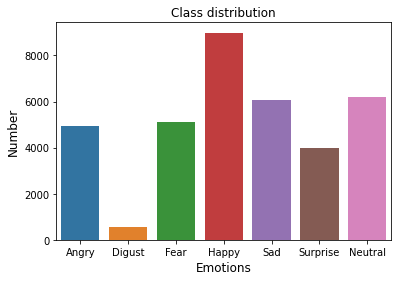

In [ ]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

In [ ]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
def maskBottom(row):
  row = row.split()
  n = len(row)//2
  return ' '.join(row[:n]+['255']*n)  
data['maskedbot'] = data['pixels'].apply(maskBottom)
   

In [ ]:
def maskTop(row):
  row = row.split()
  n = len(row)//2
  #return ' '.join(['255']*n + row[n:])
  return ' '.join(['255']*n + row[n:]) 
data['maskedtop'] = data['pixels'].apply(maskTop)

In [ ]:
data.head()

,emotion,pixels,Usage,maskedbot,maskedtop
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,255 255 255 255 255 255 255 255 255 255 255 25...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,151 150 147 155 148 133 111 140 170 174 182 15...,255 255 255 255 255 255 255 255 255 255 255 25...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,231 212 156 164 174 138 161 173 182 200 106 38...,255 255 255 255 255 255 255 255 255 255 255 25...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,255 255 255 255 255 255 255 255 255 255 255 25...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,255 255 255 255 255 255 255 255 255 255 255 25...


[['255' '255' '255' ... '255' '255' '255']
 ['255' '255' '255' ... '255' '255' '255']
 ['255' '255' '255' ... '255' '255' '255']
 ...
 ['91' '65' '42' ... '72' '56' '43']
 ['77' '82' '79' ... '105' '70' '46']
 ['77' '72' '84' ... '106' '109' '82']]
[['255' '255' '255' ... '255' '255' '255']
 ['255' '255' '255' ... '255' '255' '255']
 ['255' '255' '255' ... '255' '255' '255']
 ...
 ['44' '41' '35' ... '58' '118' '203']
 ['48' '44' '35' ... '68' '168' '211']
 ['45' '45' '41' ... '107' '199' '208']]
[['255' '255' '255' ... '255' '255' '255']
 ['255' '255' '255' ... '255' '255' '255']
 ['255' '255' '255' ... '255' '255' '255']
 ...
 ['241' '245' '250' ... '57' '101' '146']
 ['246' '250' '252' ... '78' '105' '162']
 ['250' '251' '250' ... '88' '110' '152']]
[['255' '255' '255' ... '255' '255' '255']
 ['255' '255' '255' ... '255' '255' '255']
 ['255' '255' '255' ... '255' '255' '255']
 ...
 ['65' '70' '66' ... '63' '77' '60']
 ['66' '69' '75' ... '45' '69' '76']
 ['69' '80' '77' ... '125' '6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) 

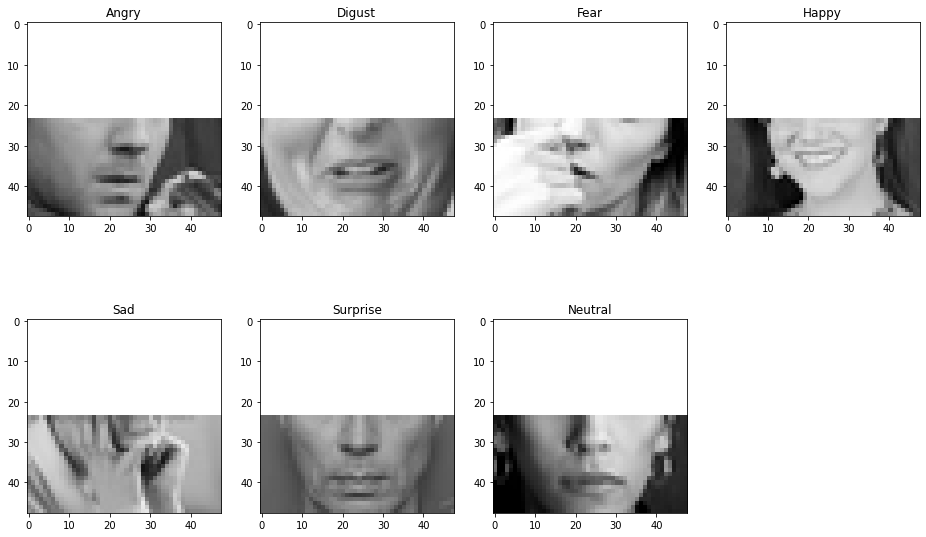

In [ ]:
def row2image(row):
    pixels, emotion = row['maskedtop'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    print(img)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show() 

In [ ]:
print(img)

[array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 34,  34,  34],
        [ 32,  32,  32],
        [ 30,  30,  30]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 33,  33,  33],
        [ 31,  31,  31],
        [ 30,  30,  30]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 30,  30,  30],
        [ 29,  29,  29],
        [ 30,  30,  30]

In [ ]:


#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))



train shape: (28709, 5), 
validation shape: (3589, 5), 
test shape: (3589, 5)


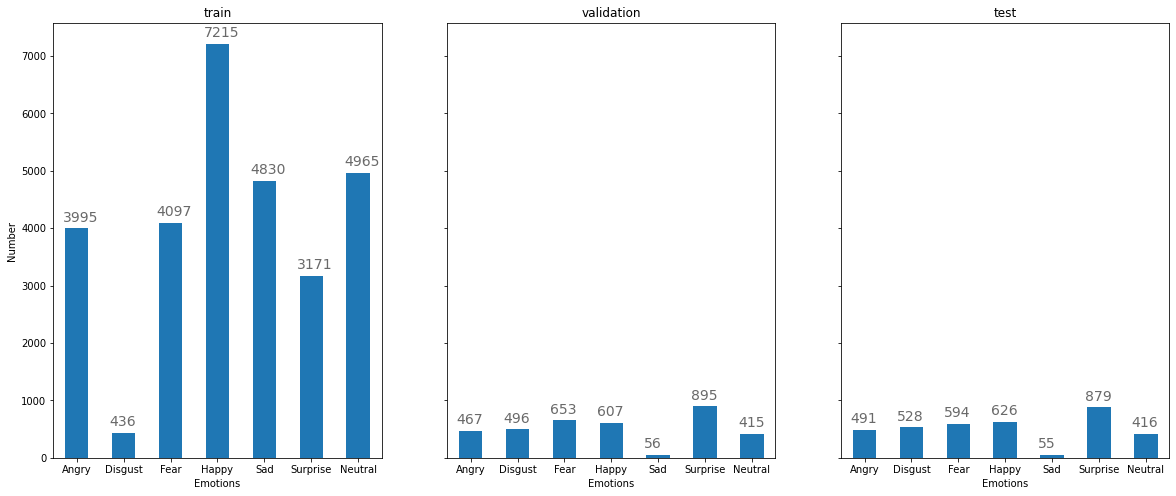

In [ ]:


# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()



In [ ]:


#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 30
batch_size = 64
num_features = 64



In [ ]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['maskedtop'] = df['maskedtop'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['maskedtop'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [ ]:


# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO1(df, dataName):
    df['maskedbot'] = df['maskedbot'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X1 = np.array(df['maskedbot'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y1 = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X1.shape, data_Y1.shape))
    return data_X1, data_Y1

    
train_X1, train_Y1 = CRNO1(data_train, "train1") #training data
val_X1, val_Y1     = CRNO1(data_val, "val1") #validation data
test_X1, test_Y1   = CRNO1(data_test, "test1") #test data



train1 _X shape: {},  train1 _Y shape: (28709, 48, 48, 1)
val1 _X shape: {},  val1 _Y shape: (3589, 48, 48, 1)
test1 _X shape: {},  test1 _Y shape: (3589, 48, 48, 1)


In [ ]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 256)       1024      
_________________________________________________________________
activation (Activation)      (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 256)       0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:


# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X, val_Y))



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
448/448 - 146s - loss: 1.7055 - accuracy: 0.3228 - val_loss: 1.9098 - val_accuracy: 0.2031
Epoch 2/30
448/448 - 82s - loss: 1.5000 - accuracy: 0.4131 - val_loss: 1.5687 - val_accuracy: 0.3862
Epoch 3/30
448/448 - 82s - loss: 1.4010 - accuracy: 0.4555 - val_loss: 1.6856 - val_accuracy: 0.3605
Epoch 4/30
448/448 - 82s - loss: 1.3460 - accuracy: 0.4793 - val_loss: 1.6675 - val_accuracy: 0.3628
Epoch 5/30
448/448 - 82s - loss: 1.3049 - accuracy: 0.4986 - val_loss: 1.3320 - val_accuracy: 0.4968
Epoch 6/30
448/448 - 82s - loss: 1.2758 - accuracy: 0.5119 - val_loss: 1.2493 - val_accuracy: 0.5227
Epoch 7/30
448/448 - 83s - loss: 1.2498 - accuracy: 0.5224 - val_loss: 1.2667 - val_accuracy: 0.5040
Epoch 8/30
448/448 - 83s - loss: 1.2343 - accuracy: 0.5273 - val_loss: 1.3240 - val_accuracy: 0.4935
Epoch 9/30
448/448 - 82s - loss: 1.2115 - accuracy: 0.5353 - val_loss: 1.3784 - val_accuracy: 0.4634
Epoch 10/30
448/448 - 82s - loss: 1.1909 - accuracy: 0.5432 - val_loss: 1.3478 - val_accur

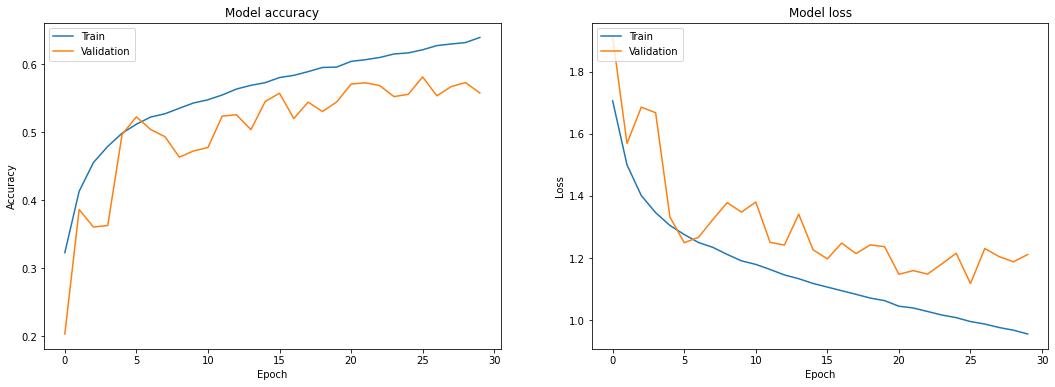

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
history.history

{'accuracy': [0.3227907717227936,
  0.4130760431289673,
  0.4554669260978699,
  0.47925737500190735,
  0.49858930706977844,
  0.5118603706359863,
  0.5224145650863647,
  0.5272562503814697,
  0.5353373289108276,
  0.5431746244430542,
  0.5478421449661255,
  0.5549131035804749,
  0.5636559724807739,
  0.5690898299217224,
  0.5730258822441101,
  0.5805496573448181,
  0.583789050579071,
  0.5892577171325684,
  0.5953882336616516,
  0.5959803462028503,
  0.6043400764465332,
  0.6068131923675537,
  0.6100874543190002,
  0.615242600440979,
  0.616844892501831,
  0.6214427351951599,
  0.6275732517242432,
  0.6299418210983276,
  0.6320666074752808,
  0.6395555138587952],
 'loss': [1.7054818868637085,
  1.5000191926956177,
  1.4009507894515991,
  1.346038818359375,
  1.3048579692840576,
  1.275757074356079,
  1.2498382329940796,
  1.2343453168869019,
  1.2115411758422852,
  1.190904140472412,
  1.1794456243515015,
  1.1632078886032104,
  1.1455427408218384,
  1.1333991289138794,
  1.11818861961

In [ ]:


test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))



CNN Model Accuracy on test set: 0.5731


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

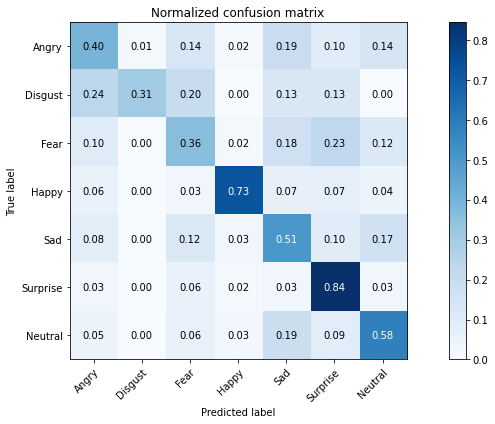

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
model1 = Sequential()

#module 1
model1.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model1.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model1.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model1.add(Flatten())

#dense 1
model1.add(Dense(2*2*2*num_features))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

#dense 2
model1.add(Dense(2*2*num_features))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

#dense 3
model1.add(Dense(2*num_features))
model1.add(BatchNormalization())
model1.add(Activation('relu'))

#output layer
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_9 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_9 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_10 (Batc (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_10 (Activation)   (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 256)      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

history = model1.fit_generator(data_generator.flow(train_X1, train_Y1, batch_size),
                                steps_per_epoch=len(train_X1) / batch_size,
                                epochs=num_epochs,
                                verbose=2, 
                                callbacks = [es],
                                validation_data=(val_X1, val_Y1))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
448/448 - 86s - loss: 1.7986 - accuracy: 0.2556 - val_loss: 2.3000 - val_accuracy: 0.1170
Epoch 2/30
448/448 - 81s - loss: 1.6860 - accuracy: 0.3146 - val_loss: 1.8199 - val_accuracy: 0.2513
Epoch 3/30
448/448 - 81s - loss: 1.6173 - accuracy: 0.3594 - val_loss: 1.6967 - val_accuracy: 0.3508
Epoch 4/30
448/448 - 81s - loss: 1.5534 - accuracy: 0.3936 - val_loss: 1.8677 - val_accuracy: 0.2154
Epoch 5/30
448/448 - 81s - loss: 1.5028 - accuracy: 0.4162 - val_loss: 1.5780 - val_accuracy: 0.3731
Epoch 6/30
448/448 - 81s - loss: 1.4649 - accuracy: 0.4385 - val_loss: 1.7879 - val_accuracy: 0.2689
Epoch 7/30
448/448 - 81s - loss: 1.4308 - accuracy: 0.4490 - val_loss: 1.6272 - val_accuracy: 0.3996
Epoch 8/30
448/448 - 82s - loss: 1.4073 - accuracy: 0.4610 - val_loss: 1.4710 - val_accuracy: 0.4252
Epoch 9/30


In [ ]:
test_true1 = np.argmax(test_Y1, axis=1)
test_pred1 = np.argmax(model1.predict(test_X1), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true1, test_pred1)))

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true1, test_pred1, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
pair_A = [model, model1]

In [ ]:
model.weights

[<tf.Variable 'conv2d_18/kernel:0' shape=(3, 3, 1, 256) dtype=float32, numpy=
 array([[[[-0.05798392, -0.06550138, -0.0330768 , ...,  0.07093888,
            0.03013073, -0.06244802]],
 
         [[-0.11025973,  0.08227847,  0.04427785, ...,  0.04371374,
           -0.04673912, -0.00983584]],
 
         [[-0.04813446,  0.04398422, -0.0066769 , ..., -0.08912836,
           -0.01383583,  0.10512968]]],
 
 
        [[[ 0.04102434,  0.08844524,  0.0079646 , ...,  0.01152795,
           -0.12935579,  0.1554304 ]],
 
         [[-0.0244277 ,  0.04292854, -0.11198749, ..., -0.01267492,
           -0.13926592, -0.11657213]],
 
         [[ 0.02780806,  0.04359999, -0.20490842, ..., -0.00140143,
            0.08790392,  0.04780351]]],
 
 
        [[[ 0.0881096 ,  0.12624481,  0.21099712, ..., -0.03565733,
           -0.00302549,  0.03021094]],
 
         [[ 0.07089172, -0.13781443,  0.13226925, ...,  0.03697456,
            0.06210063, -0.03674701]],
 
         [[ 0.0784146 , -0.1117841 , -0.0834

In [ ]:
# make predictions
yhats = [model.predict(testX) for model in models]
yhats = array(yhats)
# calculate average
outcomes = mean(yhats)

NameError: ignored

In [ ]:
model.save('/CNNModel')
loaded_model = tf.keras.models.load_model('/CNNModel')

INFO:tensorflow:Assets written to: /CNNModel/assets
